# helper functions

In [1]:
%%time
%run theory_basics.ipynb
from IPython.display import clear_output
clear_output()

CPU times: user 2min, sys: 4min 56s, total: 6min 56s
Wall time: 49.9 s


In [2]:
from scipy.ndimage import zoom
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [3]:
def calculate_frequencies(indices, dt, signal_length):
    """Calculate and interpolate frequencies"""
    time_periods = np.diff(indices) * dt
    frequencies = 1 / time_periods
    midpoints = indices[:-1] + np.diff(indices) / 2
    f = interp1d(midpoints, frequencies, kind='linear', fill_value='extrapolate', bounds_error=False)
    return f(np.arange(signal_length))

def infer_frequencies(x, dt=1/N):
    """
    Assign current frequency at each timestep.
    
    Parameters:
       x(numpy.ndarray): input, continuous signal
       dt(float): time difference between each subsequent sample (1/Fs)
       
    Returns:
       numpy.ndarray: current frequency at each timestep
    """
    # Detect peaks and troughs
    peak_indices = find_peaks(x)[0]
    trough_indices = find_peaks(-x)[0]

    # Calculate frequencies using peaks and troughs independently
    peak_freqs = calculate_frequencies(peak_indices, dt, len(x))
    trough_freqs = calculate_frequencies(trough_indices, dt, len(x))

    # Combine the frequencies calculated from peaks and troughs
    combined_freqs = (peak_freqs + trough_freqs) / 2

    return combined_freqs

In [4]:
def get_angle(f):
    return np.angle(np.fft.fft(f)[1])

def get_angles(F):
    return np.angle(np.fft.fft(F, axis=1)[:, 1])

def get_amps(F):
    return np.abs(np.fft.fft(F, axis=1)[:, 1])

In [5]:
def to_theta(x):
    return ((x + np.pi) % (2*np.pi)) - np.pi

In [6]:
def mean_angle(amps, angs):
    s = sum(amps)
    return np.angle(np.sum([
        amp * np.exp(1j*ang)
        for amp, ang in zip(amps, angs)
    ], axis=0))

In [7]:
def get_dx(X, w, i, f_I, phi, u, alpha, theta, t, delay_i, T, dt, train=True):
    I_in = f_I(w, X[i - delay_i])
    return (-X[i - 1] + phi(int(train) * u(t[i] + theta, T) + I_in)) * dt * alpha

def f_I_conv_circ_fft(signal, ker):
    return np.real(np.fft.ifft(np.fft.fft(signal) * np.fft.fft(ker)))

In [8]:
def plot_system_segment(start, end, X, W, t):
    plt.figure(figsize=(12, 5))
    gs = plt.GridSpec(1, 4, width_ratios=[1, 2, 2, 0.1])
    ax1 = plt.subplot(gs[0, 0])
    ax1.imshow(X[start:end], extent=[0, N/(end-start)*(t[end]-t[start]), t[end], t[start]])
    ax1.set_ylabel('time (s)')
    ax1.set_xlabel('x')
    ax1.set_title(r'$r(x, t)$')
    ax2 = plt.subplot(gs[0, 1])
    X_fft = np.fft.fft(X, axis=1)[:, 1]
    ax2.scatter(X_fft.real[start:end], X_fft.imag[start:end], c=t[start:end], s=1)
    ax2.set_xlabel('Re')
    ax2.set_ylabel('Im')
    ax2.set_title(r'$\mathcal{F}_{x}[r](\xi=\frac{1}{T}, t)$')
    ax3 = plt.subplot(gs[0, 2])
    W_fft = np.fft.fft(W, axis=1)[:, 1]
    w_fft_max_h = np.abs(W_fft.real[start:end]).max()+5
    w_fft_max_v = np.abs(W_fft.imag[start:end]).max()+5
    w_fft_max = max(w_fft_max_h, w_fft_max_v)
    scatter = ax3.scatter(W_fft.real[start:end], W_fft.imag[start:end], c=t[start:end], s=1)
    ax3.set_xlim(-w_fft_max, w_fft_max)
    ax3.set_ylim(-w_fft_max, w_fft_max)
    ax3.set_xlabel('Re')
    ax3.set_ylabel('Im')
    ax3.set_title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
    ax_colorbar = plt.subplot(gs[0, -1])
    cbar = plt.colorbar(scatter, cax=ax_colorbar)
    cbar.set_label('time (s)')
    plt.tight_layout()
    plt.show()

In [9]:
freqs = np.fft.fftfreq(N)

In [10]:
def get_x_from_u(u_):
    return np.fft.ifft(np.fft.fft(phi(u_)) / (tau_x/dt * 2 * np.pi * 1j * freqs + 1)).real
    
def get_w_from_x(x, delay_i):
    freqs = np.fft.fftfreq(len(x))
    x_fft = np.fft.fft(x)
    w = (
        np.abs(x_fft)**2
        * 2*np.pi*1j*freqs
        # 0.5 interpolation: correction for discretization?
        * np.conj(np.exp(-2*np.pi*1j*freqs*(delay_i)))
        / (lmbda*dt*len(x))
    )
    return np.fft.ifft(w).real

# learning

In [144]:
simulation_duration = 120.5 * T
t = np.arange(0, simulation_duration, dt)

tau_d = T / 5
delay_i = round(tau_d / dt)

x = get_x_from_u(u(t[-1] + theta, T))
w_ = get_w_from_x(x, delay_i)

In [145]:
alpha, tau_d / T, simulation_duration/T, beta

(125.0, 0.2, 120.5, 0.02)

In [146]:
coeff_set = [
    [
        np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*tau_d / T)) + k_ * 2 * np.pi,
        -(tau_d + tau_x) * 2 * np.pi / T,
        0,
        to_theta((2 * np.pi * tau_x)**3/(3*T**3))
    ]
    for k_ in range(-3, 3)
]
omega_roots = [np.roots(coeffs[::-1])[2] for coeffs in coeff_set]

In [147]:
%%time
(
    X, w, W, DW, DX
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=True, init_stimulation=True, init_travel=omega_roots[3])

CPU times: user 17.1 s, sys: 57.8 ms, total: 17.1 s
Wall time: 17.1 s


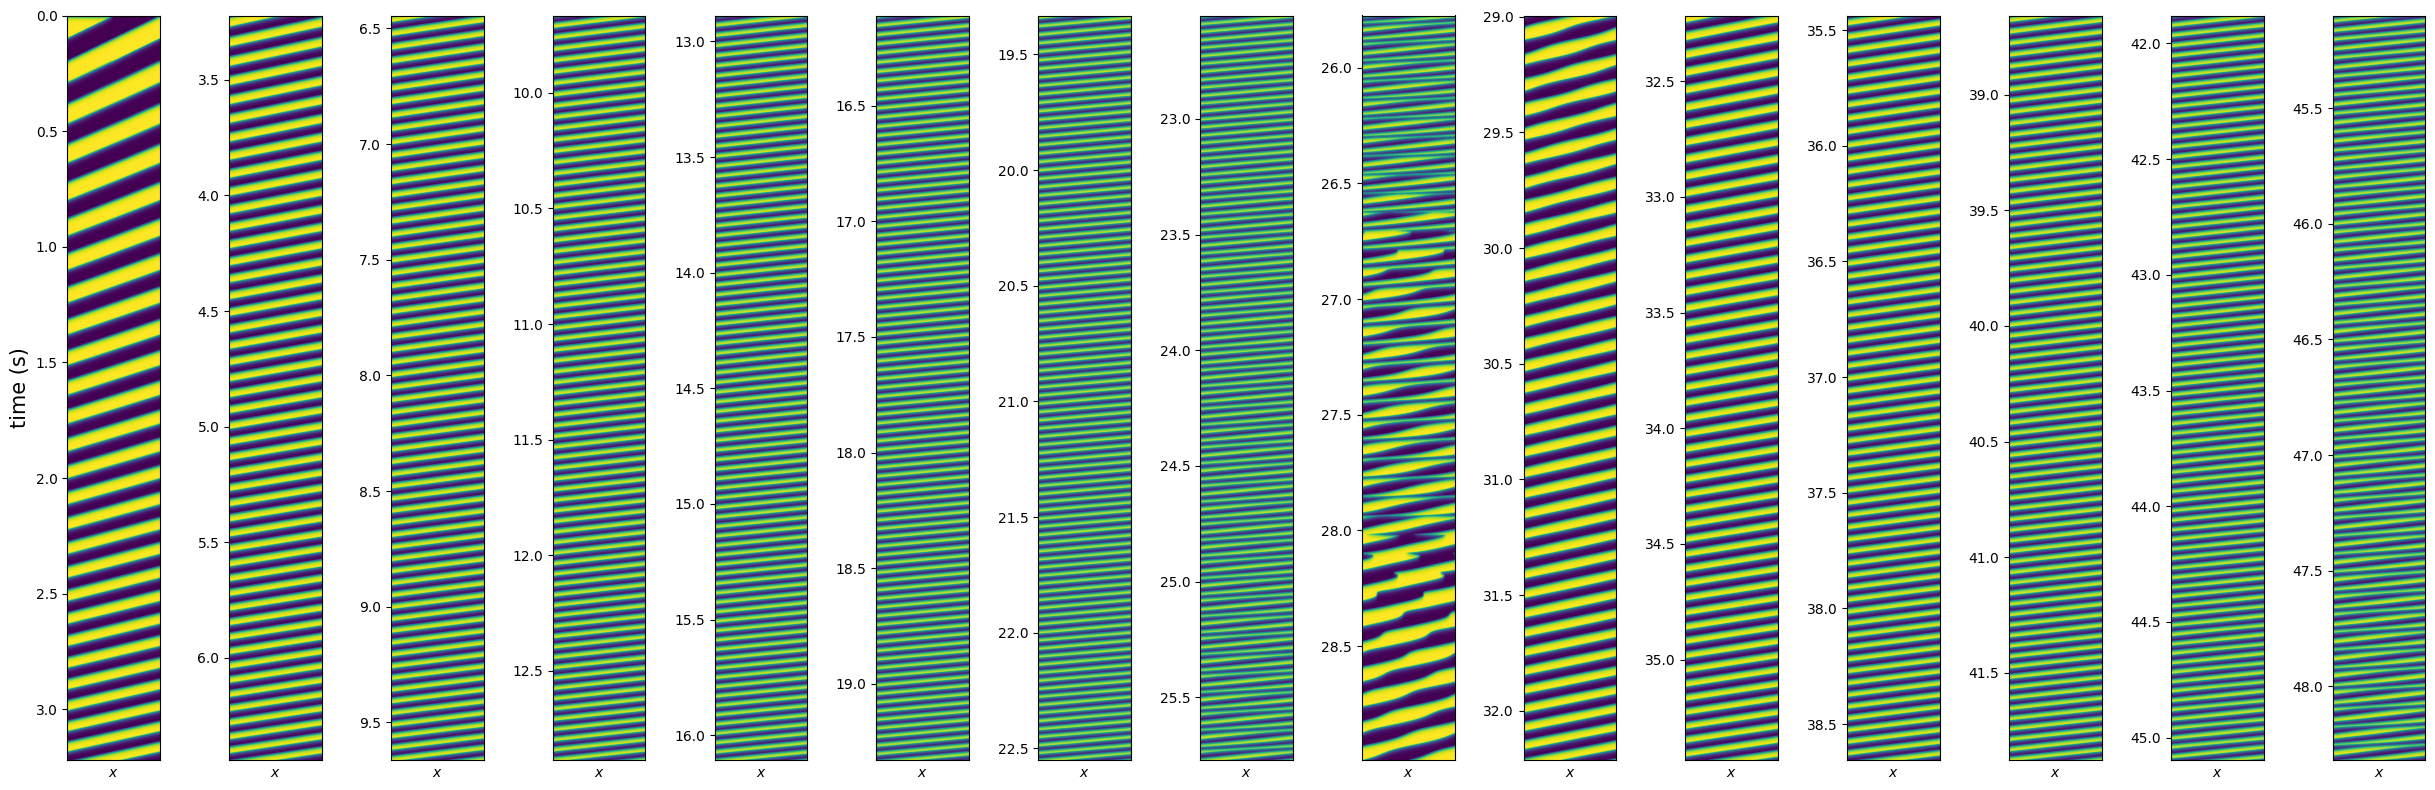

In [148]:
plot_activity(X, t, bins=15, cutoff_div=None)

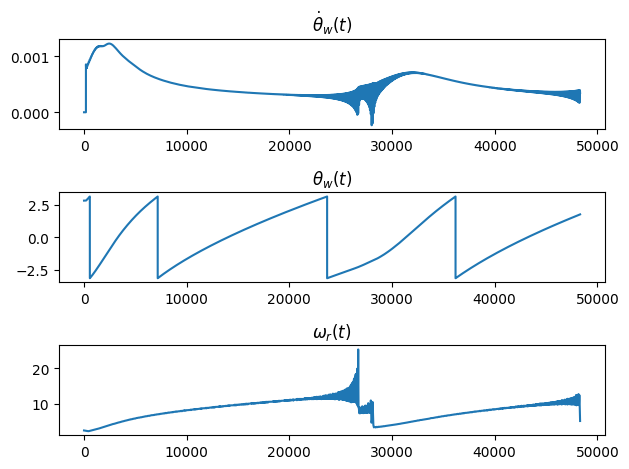

In [149]:
plt.subplot(311)
plt.plot(to_theta(get_angles(W)[10:] - get_angles(W)[9:-1]))
plt.title(r'$\dot{\theta}_w(t)$')
plt.subplot(312)
plt.plot(get_angles(W))
plt.title(r'$\theta_w(t)$')
plt.subplot(313)
plt.plot(infer_frequencies(X[:, 0]))
plt.title(r'$\omega_r(t)$')
plt.tight_layout()

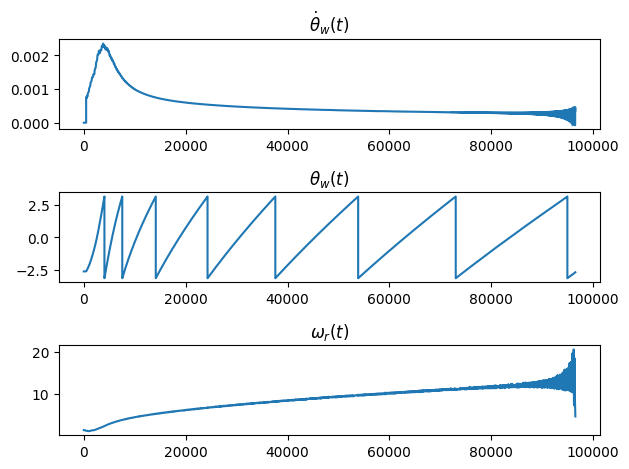

In [100]:
plt.subplot(311)
plt.plot(to_theta(get_angles(W)[10:] - get_angles(W)[9:-1]))
plt.title(r'$\dot{\theta}_w(t)$')
plt.subplot(312)
plt.plot(get_angles(W))
plt.title(r'$\theta_w(t)$')
plt.subplot(313)
plt.plot(infer_frequencies(X[:, 0]))
plt.title(r'$\omega_r(t)$')
plt.tight_layout()

$$
\tau_w\frac{\partial}{\partial t} w(\Delta x, t) = \frac{1}{T}[\dot{r}(x', t) *' r(x', t-\tau_d)](\Delta x) - \lambda {w}(\Delta x, t)
$$

$$
\tau_w\mathcal{F}_{\Delta x}\Big[\frac{\partial w}{\partial t}\Big]\Big(\xi=\frac{1}{T}, t\Big)\Big) + \lambda \mathcal{F}_{\Delta x}[w]\Big(\xi=\frac{1}{T}, t\Big) = \frac{1}{T}\mathcal{F}_{\Delta x}[\dot{r}(x, t) *' r(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)
$$

$$
\Big(\lambda + 2 \pi i \frac{\tau_w\omega_w(t)}{T}\Big)\mathcal{F}_{\Delta x}[w]\Big(\xi=\frac{1}{T}, t\Big) = \frac{1}{T}\mathcal{F}_{\Delta x}[\dot{r}(x, t) *' r(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)
$$

$$
\text{arg}\Bigg(\Big(\lambda + 2 \pi i \frac{\tau_w\omega_w(t)}{T}\Big)\mathcal{F}_{\Delta x}[w]\Big(\xi=\frac{1}{T}, t\Big)\Bigg) = \frac{\text{arg}(i) - \text{arg}(e^{-2\pi i \frac{\omega_r(t)\tau_d}{T}})}{T}
$$

$$
\text{arg}\Big(\lambda + 2 \pi i \frac{\tau_w\omega_w(t)}{T}\Big) + \theta_w(t) = \frac{\text{arg}(i) - \text{arg}(e^{-2\pi i \frac{\omega_r(t)\tau_d}{T}})}{T}
$$

$$
\text{arctan}\Big(\frac{2 \pi\tau_w\omega_w(t)}{\lambda T}\Big) + \theta_w(t) = \frac{\text{arg}(i) - \text{arg}(e^{-2\pi i \frac{\omega_r(t)\tau_d}{T}})}{T}
$$

(-0.2, 0.2)

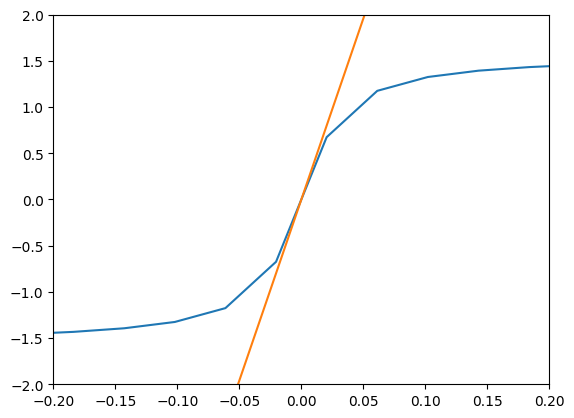

In [152]:
plt.plot(np.linspace(-1, 1), np.arctan(2*np.pi*tau_w*np.linspace(-1, 1)/lmbda/T))
plt.plot(np.linspace(-1, 1), 2*np.pi*tau_w/lmbda/T * np.linspace(-1, 1))
plt.ylim(-2, 2)
plt.xlim(-0.2, 0.2)

linear approximation

$$
\omega_w(t) = \frac{\lambda}{2 \pi\tau_w}\Big({\text{arg}(i) - \text{arg}(e^{-2\pi i \frac{\omega_r(t)\tau_d}{T}})} - T\theta_w(t)\Big)
$$

$$
\frac{\partial}{\partial t}\theta_w(t) = \frac{\lambda}{\tau_w}\Big({\text{arg}(i) - \text{arg}(e^{-2\pi i \frac{\omega_r(t)\tau_d}{T}})} - T\theta_w(t)\Big)
$$

$$
\frac{\partial}{\partial t}\theta_r(t) = \frac{T(2\pi k + \theta_{w}(t))}{(\tau_d + \tau_r)}, k \in \mathbb{Z}
$$

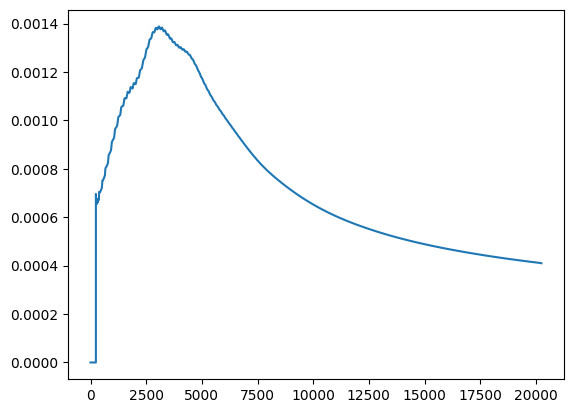

In [50]:
plt.plot(to_theta(get_angles(W)[1:] - get_angles(W)[:-1]))

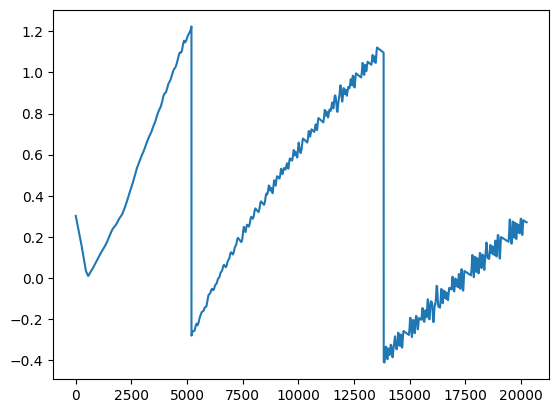

In [45]:
plt.plot(lmbda / tau_w * (to_theta(np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*infer_frequencies(X[:, 0])*tau_d / T)) - T * get_angles(W))))

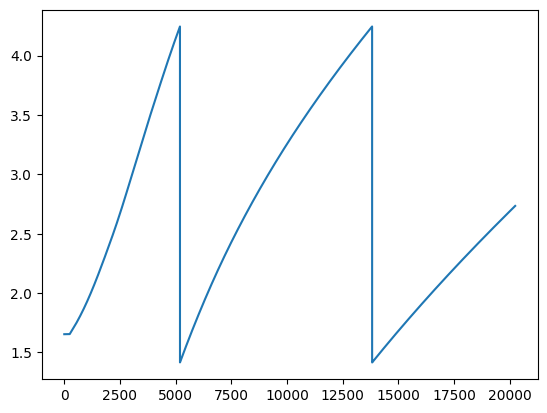

In [31]:
plt.plot(T * (2 * np.pi * 1 + get_angles(W)) / (tau_d + tau_x) / 2 / np.pi)

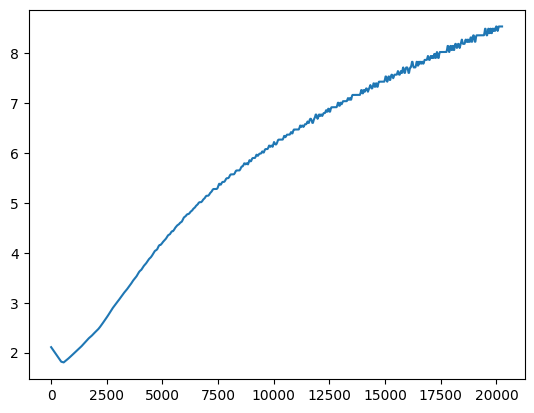

In [19]:
plt.plot(infer_frequencies(X[:, 0]))